## Statistical Evaluation of the Models

In this notebook, we compare the out-of-sample forecasts of each model for different forecast horizons by evaluating the Root Mean Square Forecast Error (RMSFE) and Mean Absolute Forecast Error (MAFE).
* $$\text{RMSFE}_{h} = \sqrt{\frac{1}{N * (T_{\text{test}} - h + 1)}\sum_{n = 1}^{N}\sum_{t = h}^{T_{\text{test}}} (\log \widehat{RV}_{\{n, t \lvert t - h\}} - \log {RV}_{\{n, t\}})^2}$$
* $$\text{MAFE}_{h} = \frac{1}{N * (T_{\text{test}} - h + 1)}\sum_{n = 1}^{N}\sum_{t = h}^{T_{\text{test}}} \left|\log \widehat{RV}_{\{n, t \lvert t - h\}} - \log {RV}_{\{n, t\}} \right|$$

In [1]:
import pandas as pd
import numpy as np

trading_days = [245, 244, 244, 244, 243, 244, 243, 243, 242, 242] # trading days per year
window_size = np.sum(trading_days[0:-1]) # 2192 rolling window
forecast_steps = trading_days[-1] # last year as out-of-sample forecast

# for 1-step-ahead forecast : we need to forecast 242 (start from 1) days
# for 5-step-ahead forecast : we need to forecast 242 - 5 + 1 = 238 (start from 5) days
# for 22-step-ahead forecast : we need to forecast 242 - 22 + 1 = 221 (start from 22) days

# for h-step-ahead forecast : in-sample is from [step to (step + window_size)]
# forecast is (step + window_size + h)

def get_target(forecast_horizon):
    log_rv = pd.read_csv('../data/realized_volatility/log_rv_table.csv', index_col=0)
    target_horizon = log_rv.iloc[window_size+forecast_horizon-1:, :]
    return target_horizon

def cal_metrics(targets, forecasts):
    targets = np.array(targets)
    forecasts = np.array(forecasts)
    
    MSE = (targets - forecasts) ** 2
    MAE = np.abs(targets - forecasts)
    
    return MSE, MAE

model_list = ['VAR', 'LSTM', 'GRU', 'MLSTMF', 'MGRUF']
horizon_list = [1, 5, 22]
forecast_size = 242

result_df = pd.DataFrame(columns=['RMSE_1', 'RMSE_5', 'RMSE_22', 'MAE_1', 'MAE_5', 'MAE_22'], index=model_list)

for horizon in horizon_list:
    targets = get_target(horizon)
    for i, model in enumerate(model_list):
        forecasts = pd.read_csv(f'../results/forecasts/{model}_h_{horizon}.csv', index_col=0)
        MSE, MAE = cal_metrics(targets, forecasts)
        result_df.loc[model, f'RMSE_{horizon}'] = np.sqrt(np.mean(MSE))
        result_df.loc[model, f'MAE_{horizon}'] = np.mean(MAE)
# result_df.to_csv('../results/evaluations/Stat_eval.csv')
pd.set_option('display.float_format', '{:.3f}'.format)

result_df

,RMSE_1,RMSE_5,RMSE_22,MAE_1,MAE_5,MAE_22
VAR,0.582,0.709,0.825,0.451,0.554,0.646
LSTM,0.620,0.674,0.743,0.482,0.525,0.585
GRU,0.606,0.664,0.733,0.472,0.517,0.575
MLSTMF,0.606,0.672,0.740,0.471,0.524,0.582
MGRUF,0.599,0.661,0.717,0.466,0.518,0.562


## Detail Examination

Beyond the RMSFE and MAFE, we also examine the cumulative forecast error for Huatai Securities Co., Ltd. (stock symbol is sh.6001688) for each model.

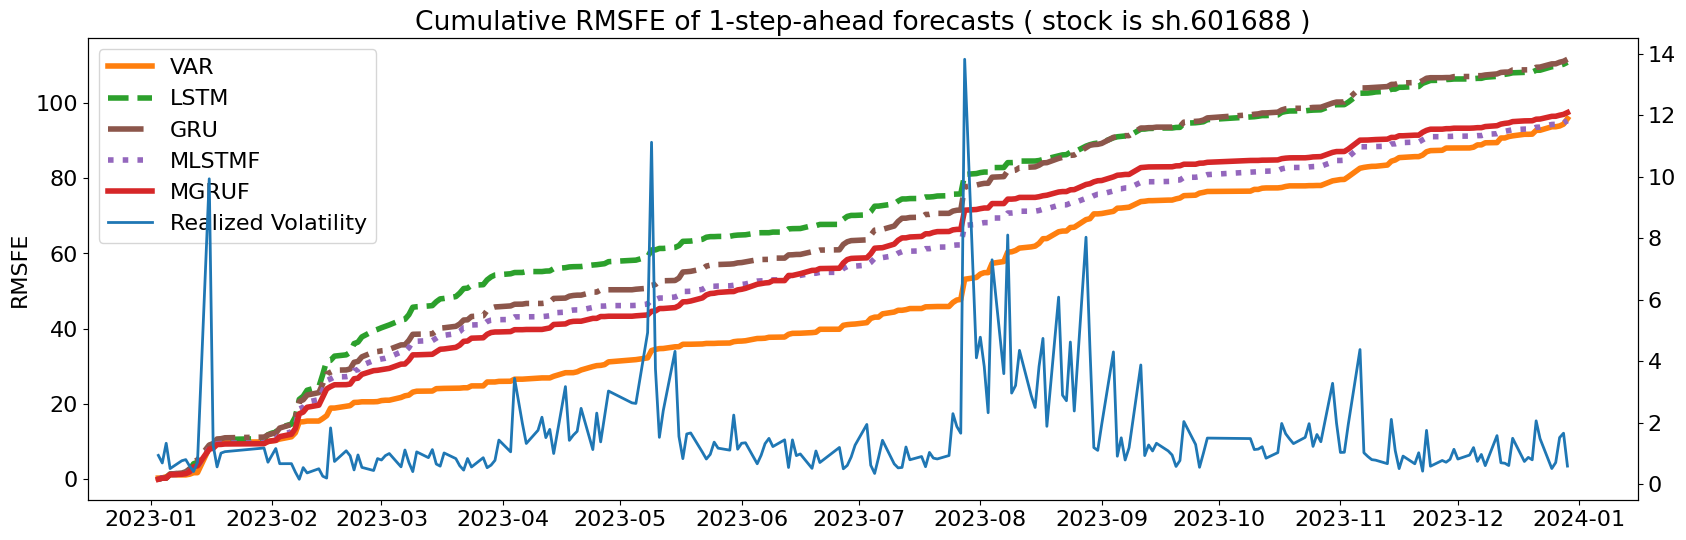

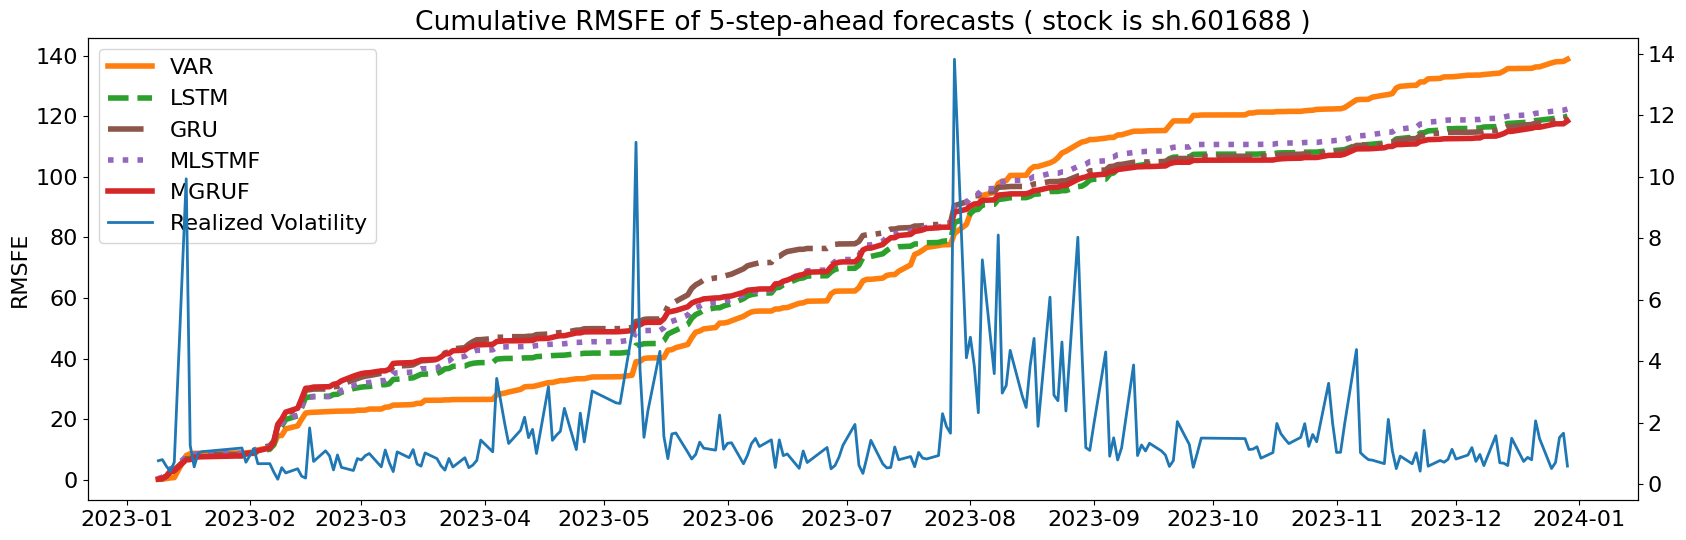

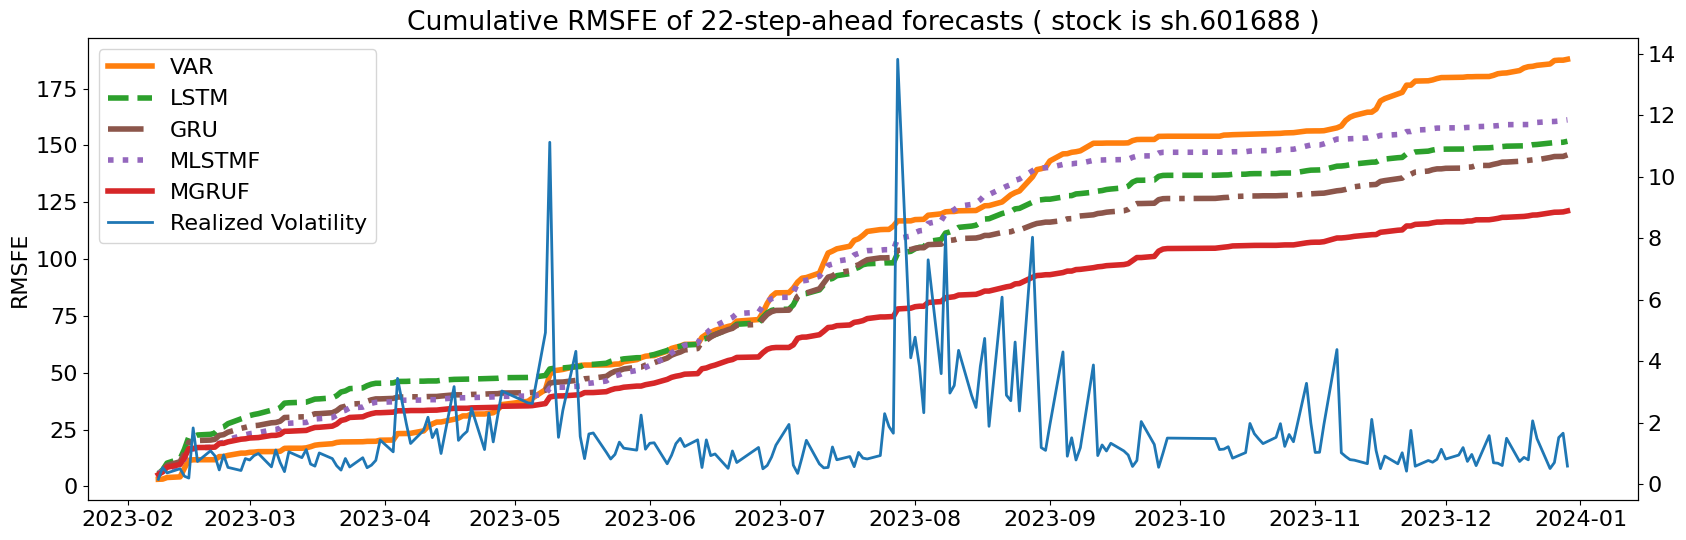

In [2]:
stocks = pd.read_csv('../results/forecasts/GRU_h_22.csv', index_col=0).columns
colors = ['tab:orange', 'tab:green', 'tab:brown', 'tab:purple', 'tab:red', 'tab:blue']

def cum_error(horizon, metrics, model_list, stock):
    lines = []
    c_index = 0
    targets = get_target(horizon)
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    fig, ax1 = plt.subplots(figsize=(20, 6))

    line_list = ['-', '--', '-.', ':', '-']
    for i, model in enumerate(model_list):
        forecasts = pd.read_csv(f'../results/forecasts/{model}_h_{horizon}.csv', index_col=0)
        indices = forecasts.index
        RMSFE, MAFE = cal_metrics(targets, forecasts)
        stock_index = stocks.get_loc(stock)
        if metrics == 'MAFE':
            error = MAFE
        elif metrics == 'RMSFE':
            error = RMSFE
        cum_errors = np.cumsum(error[:, stock_index])
        
        df = pd.DataFrame(cum_errors, index=pd.to_datetime(indices, format='%Y-%m-%d'))
        line, = ax1.plot(pd.to_datetime(indices, format='%Y-%m-%d'), cum_errors, color=colors[c_index], label=model, linestyle=line_list[i], linewidth=4)
        c_index += 1
        ax1.set_ylabel(metrics)
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        lines.append(line)

    ax2 = ax1.twinx()
    line, = ax2.plot(pd.to_datetime(indices, format='%Y-%m-%d'), np.exp(targets.iloc[:, stock_index]), color=colors[c_index], label='Realized Volatility', linewidth=2)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(f'Cumulative {metrics} of {horizon}-step-ahead forecasts ( stock is {stocks[stock_index]} )')
    lines.append(line)
    
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc=0)
    plt.savefig(f'../results/evaluations/cum_{metrics}_{horizon}.pdf', dpi=300)

model_list = ['VAR', 'LSTM', 'GRU', 'MLSTMF', 'MGRUF']
import matplotlib as mpl
mpl.rc('font', size=16)

cum_error(1, 'RMSFE', model_list, 'sh.601688')
cum_error(5, 'RMSFE', model_list, 'sh.601688')
cum_error(22, 'RMSFE', model_list, 'sh.601688')